In [23]:
## Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
# Read and explore date
# Using df.info() to display information about the DataFrame, including the number of rows and columns, the dtypes of each column, and the number of non-null values in each column. 
df = pd.read_csv(r"C:\Users\admin\Desktop\Labeled_Data.csv") 
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52415 entries, 0 to 52414
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         52412 non-null  float64
 1   comment_id         52415 non-null  object 
 2   comment_parent_id  52415 non-null  object 
 3   comment_body       52415 non-null  object 
 4   subreddit          52415 non-null  object 
 5   Sentiment          52415 non-null  object 
dtypes: float64(1), object(5)
memory usage: 2.4+ MB


In [4]:
# Remove any rows with missing or null values from the Df
df = df.dropna()

In [5]:
# split the comment_body and Sentiment columns of the df into training and testing sets(test size=20%, train size=80%,Random seed=42 )   
train_data, test_data, train_labels, test_labels = train_test_split(
    df['comment_body'], df['Sentiment'], test_size=0.2, random_state=42
)


In [6]:
# Using Tokenizer object  with a num_words parameter of 5000, to limits the number of unique words to consider in the tokenization process. 
# The fit_on_texts method fits the tokenizer on the training data.
# Using the texts_to_sequences method to converts the text data to sequences. 
# Call pad_sequences functio to adds extra zeros to the end of each sequence to make all of them the same length,(in this case is set to a maximum of 100)

tokenizer = Tokenizer(num_words=5000) 
tokenizer.fit_on_texts(train_data)
train_data = tokenizer.texts_to_sequences(train_data)
test_data = tokenizer.texts_to_sequences(test_data)
maxlen = 100
train_data = pad_sequences(train_data, padding='post', maxlen=maxlen)
test_data = pad_sequences(test_data, padding='post', maxlen=maxlen)

In [7]:
# Using OneHotEncoder() to convert categorical variables into a binary 
# fit_transform() is used on the training data to both fit the encoder to the data and transform it into binary format,
# transform() is used on the test data to transform it into the same binary format as the training data, based on the encoding scheme learned from the training data
encoder = OneHotEncoder()
train_labels = encoder.fit_transform(train_labels.values.reshape(-1,1)).toarray()
test_labels = encoder.transform(test_labels.values.reshape(-1,1)).toarray()


In [8]:
# Creating a Sequential model (the output of one layer is fed as input to the next layer) consists of :
# an embedding layer  input dimension of 5000, an output dimension of 128, and an input length of maxlen,
# followed by a LSTM layer with 128 units and 20% dropout rate,
# and finally a dense layer with softmax activation and 3 output units (softmax is suitable activation function for multi-class classification)
model = Sequential()
model.add(Embedding(5000, 128, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))


In [9]:
# categorical_crossentropy loss function is used because it's proper for multiclass classification.
# adam optimizer is used to minimize the loss function.
# Using metrics to evaluate the performance of the model during training and testing.


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

In [10]:
# Prints a summary of the model's architecture, including the layers, output shape of each layer, and the number of trainable parameters.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 771,971
Trainable params: 771,971
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Using train_data and train_labels to train the model, and the validation_data is used to evaluate the model for 5 itterations 
# nd batch_size specifies the number of training samples that should be used in each training iteration( in this case =32)
history=model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=5, batch_size=32)


Epoch 1/5
1311/1311 [==============================] - 433s 325ms/step - loss: 0.8305 - accuracy: 0.6578 - precision: 0.6839 - recall: 0.5962 - val_loss: 0.7524 - val_accuracy: 0.7020 - val_precision: 0.7340 - val_recall: 0.6361
Epoch 2/5
1311/1311 [==============================] - 404s 308ms/step - loss: 0.6457 - accuracy: 0.7425 - precision: 0.7650 - recall: 0.7088 - val_loss: 0.5763 - val_accuracy: 0.7559 - val_precision: 0.7778 - val_recall: 0.7378
Epoch 3/5
1311/1311 [==============================] - 384s 293ms/step - loss: 0.4956 - accuracy: 0.8059 - precision: 0.8201 - recall: 0.7890 - val_loss: 0.4690 - val_accuracy: 0.8141 - val_precision: 0.8274 - val_recall: 0.7984
Epoch 4/5
1311/1311 [==============================] - 373s 285ms/step - loss: 0.3875 - accuracy: 0.8557 - precision: 0.8646 - recall: 0.8443 - val_loss: 0.4295 - val_accuracy: 0.8318 - val_precision: 0.8409 - val_recall: 0.8188
Epoch 5/5
1311/1311 [==============================] - 366s 279ms/step - loss: 0.333

In [30]:
# Using metrics to evaluate the trained model on the test dataset
loss,accuracy, precision, recall = model.evaluate(test_data, test_labels, verbose=False) 
print("Test Accuracy: {:.4f}".format(accuracy))
print("Test Precision: {:.4f}".format(precision))
print("Test Recall: {:.4f}".format(recall))

Test Accuracy: 0.8389
Test Precision: 0.8483
Test Recall: 0.8313


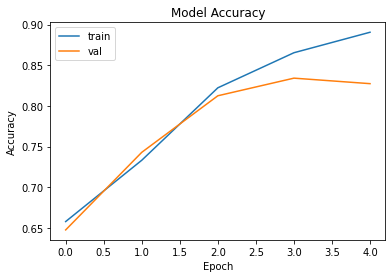

In [ ]:
#  Using matplotlib.pyplot to plot the accuracy and loss of the model during training and validation,.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Acc.jpg")
plt.show()

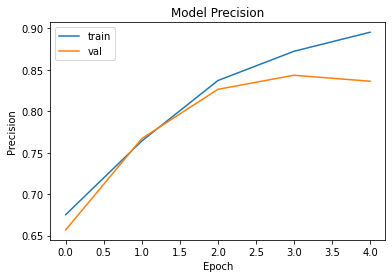

In [ ]:
# Using matplotlib.pyplot to plot the precision of the model during training and validation . 
# Using Precision metric to evaluate the ability of the model to correctly identify positive instances, and minimizing the false positives. 
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Prec.jpg")
plt.show()

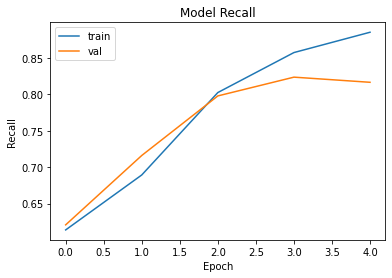

In [ ]:
# Using matplotlib.pyplot to plot the recall of the model during training and validation . 
# Using recall metric to evaluate the ability of the model to correctly identify positive instances, and minimizing the false positives.
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Recall.jpg")
plt.show()

In [28]:
# Using a trained model to get the predicted class probabilities and true classes for the test dataset . 
# The predicted class probabilities are obtained using the model.predict() function on the test data, and returns an array of probabilities for each test instance. 
# Using the np.argmax() function with axis 1 to find the index of the highest value in the test_labels array .
y_pred_classes = model.predict(test_data)
y_true = np.argmax(test_labels, axis=1)

# make sure y_pred has the same shape as y_true
if y_pred_classes.shape != y_true.shape:
    y_pred_classes = np.argmax(model.predict(test_data), axis=1)

328/328 [==============================] - 12s 37ms/step


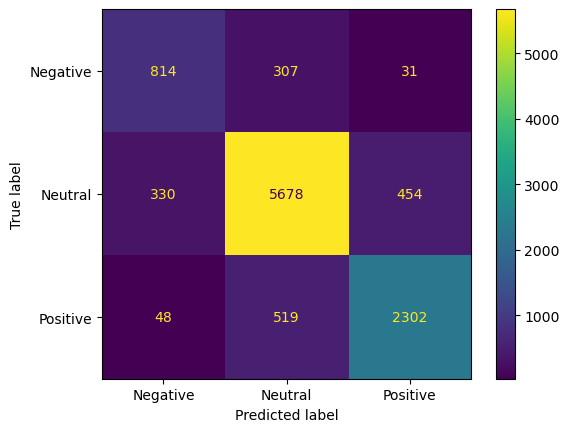

In [27]:
# The confusion_matrix function is used to generate the confusion matrix by comparing the predicted classes y_pred_classes and true classes y_true. 
# Then the ConfusionMatrixDisplay function is used to create a display object with the matrix and label names. 

matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(matrix, display_labels = ['Negative','Neutral', 'Positive'])
disp.plot()